In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from functools import reduce
import os

In [2]:
# Flags
LOG_DIR = ".graph_cnn"
TRAIN_DIR = 'resTrain/'


In [3]:
label = pd.read_csv("labels.csv", delimiter=',', index_col=0) # 120 labels
labelOneHot = pd.get_dummies(label.breed) # 120 labels

# train and validation set
val_set = labelOneHot.sample(n=222, replace=False)
labelOneHot  = labelOneHot.drop(labels=val_set.index, axis=0)

global curr_batch  # flag to track current batch being fed in each epoch
curr_batch = 0     # first initialization, re-initialize with caution

'''
input batch-size, default = 100
uses global variable curr_batch to remember current batch location
returns tuple (flag for next batch, list of files, list of labels, 4-d array->(batch, h, w, c))
'''
def next_batch(batch_size=25, random=False):
    next_batch = True
    if random:
        label_list = val_set.sample(n=batch_size, replace=False)
        batch_list = label_list.index
    else:
        global curr_batch
        start = curr_batch*batch_size
        end   = (curr_batch+1)*batch_size
        # print("feeding Batch : " + str(curr_batch))
        # Check is it's last batch
        if ((curr_batch+1)*batch_size>len(labelOneHot)):
            end = len(labelOneHot)-1
            next_batch = False
        label_list = labelOneHot[start:end]
        batch_list = label_list.index

    
    batch = []
    for img in batch_list:
        pic = cv2.imread(TRAIN_DIR+img+".jpg", cv2.IMREAD_UNCHANGED)
        batch.append(pic)
    batch = np.stack(batch, axis=0)
    if not(random):
        curr_batch = curr_batch + 1
    
    return next_batch, batch_list, np.argmax(label_list.values, axis=1), batch

'''
input  : takes an iterator ( of numbers ), as list, tuple, range
return : product of all numbers in iterator
'''
reduce_mul = lambda list_ : reduce(lambda x,y: x*y, list_)

In [4]:
''' Image Transformation Definitions '''
'''
randomly crop image
set kee_dim true to keep input and out put dimensions same
cropped height and width fraction
'''
def random_crop(input, h_frac=0.6, w_frac=0.6, keep_dim=True):
    height, width, _ = input.shape
    h, w = int(h_frac*height), int(w_frac*width)
    y, x = np.random.randint(0, height-h), np.random.randint(0, width-w)
    if keep_dim:
        return cv2.resize(input[x:x+w, y:y+h, :], (height, width), interpolation=cv2.INTER_CUBIC)
    else:
        return input[x:x+w, y:y+h, :]

'''
Performs gaussian or median blur of random strength
upper limit of blur strength can be passes as parameter
'''
def random_blur(input, max_strength=0.2):
    h, w, _ = input.shape
    rand = np.random.randint(0, max_strength*h)
    if rand%2==0:
        max_strength = max_strength/4
        a, b = np.random.randint(1, int(max_strength*h)), np.random.randint(1, int(max_strength*w))
        a, b = 2*a+1, 2*b+1 
        return cv2.GaussianBlur(input,(a, b),0)
    else:
        rand = 2*int(rand/4)+1
        return cv2.medianBlur(input,rand)

'''
randomly rotate the image about center with scale factor of 1.1
'''
def random_rotate(input):
    rows, cols, _ = input.shape
    theta = np.random.randint(0, 360)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1.1)
    return cv2.warpAffine(input,M,(cols,rows))

def random_noise(input, strength=None):
    a, b, c = input.shape
    if strength==None:
        strength = np.random.randint(0, 50)
    noise = np.random.randn(a, b, c)
    out = input+strength*noise
    a = np.max(out); b = min(0, np.min(out))
    return np.uint8(254/(a-b)*(out-b))
     
def random_skew():

    pts1 = np.float32([[50,50],[200,50],[50,200]])
    pts2 = np.float32([[10,100],[200,50],[100,250]])

    M = cv2.getAffineTransform(pts1,pts2)

    dst = cv2.warpAffine(img,M,(cols,rows))


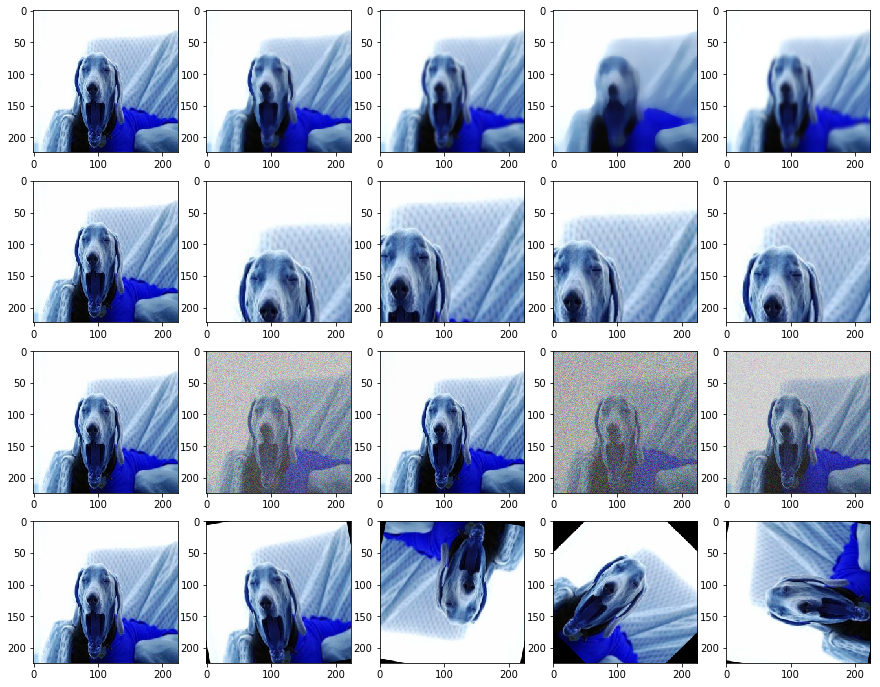

In [6]:
_, _, _, dog_img = next_batch(batch_size=1, random=True)

rand_transformation = [random_blur, random_crop, random_noise, random_rotate]

nrow = len(rand_transformation)
ncol = 5

fig, ax = plt.subplots(nrows=nrow, ncols=ncol)
fig.set_figwidth(15)
fig.set_figheight(12)

for i in range(nrow):
    ax[i,0].imshow(dog_img[0], interpolation='nearest', aspect='auto')
    for j in range(1,ncol):
        ax[i,j].imshow(rand_transformation[i](dog_img[0]), interpolation='nearest', aspect='auto')

In [7]:
rand_transformation = [random_blur, random_crop, random_noise, random_rotate]
num_trans = len(rand_transformation)
def imgaug(label, image):
    list_label = []
    list_image = []
    for lab,img in zip(label,image):
        list_label.append(lab)
        list_image.append(img)
        for i in range(num_trans):
            list_label.append(lab)
            list_image.append(rand_transformation[i](img))
    return list_label, np.stack(list_image, axis=0)

In [8]:
# Model Graph Definition
tf.reset_default_graph()

x_image = tf.placeholder(tf.float32, shape=(None, 224, 224, 3), name="X")
y       = tf.placeholder(tf.int32, shape=(None,), name="Y")
is_training = tf.placeholder(tf.bool, name="trainFlag")

c1 = tf.layers.conv2d(x_image, filters=8, kernel_size=[5,5], padding="SAME", activation=tf.nn.relu, name="conv1")
p1 = tf.layers.max_pooling2d(c1, pool_size=[2,2], strides=2, name="pool1")


c2 = tf.layers.conv2d(p1, filters=16, kernel_size=[5,5], padding="SAME", activation=tf.nn.relu, name="conv2")
p2 = tf.layers.max_pooling2d(c2, pool_size=[2,2], strides=2, name="pool2")


# c3 = tf.layers.conv2d(p2, filters=32, kernel_size=[3,3], padding="SAME", activation=tf.nn.relu, name="conv3")
# p3 = tf.layers.max_pooling2d(c3, pool_size=[4,4], strides=4, name="pool3")

p3 = p2

# Dense Layer
ndim = reduce_mul(p3.get_shape().as_list()[1:])
p3_flat = tf.reshape(p3, [-1, ndim])
dense = tf.layers.dense(inputs=p3_flat, units=3136, activation=tf.nn.relu, name="fc1")
dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training, name="dropout") # Set this flag to false while making prediction

# Logits Layer
logits = tf.layers.dense(inputs=dropout, units=120, name="fc2")

predictions = {
  "classes": tf.argmax(input=logits, axis=1),
  "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
}

# Calculate Loss
loss = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)
xent = tf.reduce_mean(loss)

# Configure the Training 
optimizer = tf.train.AdagradOptimizer(learning_rate=0.01)
train_step = optimizer.minimize(
    loss=xent,
    global_step=tf.train.get_global_step())

# Add evaluation metrics
eval_metric = {
    "accuracy": tf.metrics.accuracy(labels=y, predictions=predictions["classes"])}


tf.summary.scalar('cross_entropy', xent, )
tf.summary.scalar('accuracy', eval_metric["accuracy"][0])
summ = tf.summary.merge_all()

In [9]:
# Training
batchNext = True
curr_batch = 0
counter = 0

with tf.Session() as sess:
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    saver  = tf.train.Saver()
    sess.run(init_g)
    sess.run(init_l)
    saver.recover_last_checkpoints(LOG_DIR)
    for epoch in range(4):
        curr_batch = 0
        while(batchNext):
            batchNext, _, batch_label, image = next_batch(25)  # A batch of images with shape [batch_size, height, width, 3].
            _, _, batch_label_cv, image_cv = next_batch(25, True) # randomly sample images for cross-validation [batch_size, height, width, 3].
            
            # apply image augmentation
            batch_label, image = imgaug(batch_label, image)
            batch_label_cv, image_cv = imgaug(batch_label_cv, image_cv)  
            
            [train_accuracy, s] = sess.run([eval_metric["accuracy"], summ], feed_dict={x_image: image, y: batch_label, is_training:False})
            [train_accuracy_cv, s_cv] = sess.run([eval_metric["accuracy"], summ], feed_dict={x_image: image_cv, y: batch_label_cv, is_training:False})
            writer.add_summary(s, counter)
            writer.add_summary(s_cv, counter)
            print("Epoch: %2d, Iteration: %3d, training accuracy : %6.5f , cv_accuracy: %6.5f"%(epoch, counter, train_accuracy[0], train_accuracy_cv[0]))
#             print("Epoch: %2d, Iteration: %3d, training accuracy : %6.5f"%(epoch, counter, train_accuracy[0]))
            if counter % 20 == 0:
                saver.save(sess, os.path.join(LOG_DIR, "kaggle-dog-identification-cnn.ckpt"), counter)
            sess.run(train_step, feed_dict={x_image: image, y: batch_label, is_training:True})
            counter = counter+1      


Epoch:  0, Iteration:   0, training accuracy : 0.00000 , cv_accuracy: 0.00000
Epoch:  0, Iteration:   1, training accuracy : 0.00000 , cv_accuracy: 0.00000
Epoch:  0, Iteration:   2, training accuracy : 0.00000 , cv_accuracy: 0.00000
Epoch:  0, Iteration:   3, training accuracy : 0.00000 , cv_accuracy: 0.00000
Epoch:  0, Iteration:   4, training accuracy : 0.00000 , cv_accuracy: 0.00000
Epoch:  0, Iteration:   5, training accuracy : 0.00000 , cv_accuracy: 0.00000
Epoch:  0, Iteration:   6, training accuracy : 0.00200 , cv_accuracy: 0.00246
Epoch:  0, Iteration:   7, training accuracy : 0.00229 , cv_accuracy: 0.00320
Epoch:  0, Iteration:   8, training accuracy : 0.00350 , cv_accuracy: 0.00329
Epoch:  0, Iteration:   9, training accuracy : 0.00356 , cv_accuracy: 0.00547
Epoch:  0, Iteration:  10, training accuracy : 0.00520 , cv_accuracy: 0.00495
Epoch:  0, Iteration:  11, training accuracy : 0.00473 , cv_accuracy: 0.00487
Epoch:  0, Iteration:  12, training accuracy : 0.00467 , cv_accu

Epoch:  0, Iteration: 106, training accuracy : 0.00864 , cv_accuracy: 0.00864
Epoch:  0, Iteration: 107, training accuracy : 0.00860 , cv_accuracy: 0.00856
Epoch:  0, Iteration: 108, training accuracy : 0.00856 , cv_accuracy: 0.00859
Epoch:  0, Iteration: 109, training accuracy : 0.00870 , cv_accuracy: 0.00866
Epoch:  0, Iteration: 110, training accuracy : 0.00862 , cv_accuracy: 0.00865
Epoch:  0, Iteration: 111, training accuracy : 0.00868 , cv_accuracy: 0.00865
Epoch:  0, Iteration: 112, training accuracy : 0.00871 , cv_accuracy: 0.00871
Epoch:  0, Iteration: 113, training accuracy : 0.00871 , cv_accuracy: 0.00878
Epoch:  0, Iteration: 114, training accuracy : 0.00881 , cv_accuracy: 0.00884
Epoch:  0, Iteration: 115, training accuracy : 0.00880 , cv_accuracy: 0.00880
Epoch:  0, Iteration: 116, training accuracy : 0.00879 , cv_accuracy: 0.00886
Epoch:  0, Iteration: 117, training accuracy : 0.00889 , cv_accuracy: 0.00885
Epoch:  0, Iteration: 118, training accuracy : 0.00881 , cv_accu

Epoch:  0, Iteration: 212, training accuracy : 0.00970 , cv_accuracy: 0.00983
Epoch:  0, Iteration: 213, training accuracy : 0.00984 , cv_accuracy: 0.00993
Epoch:  0, Iteration: 214, training accuracy : 0.00991 , cv_accuracy: 0.00992
Epoch:  0, Iteration: 215, training accuracy : 0.00993 , cv_accuracy: 0.01006
Epoch:  0, Iteration: 216, training accuracy : 0.01004 , cv_accuracy: 0.01001
Epoch:  0, Iteration: 217, training accuracy : 0.01001 , cv_accuracy: 0.01000
Epoch:  0, Iteration: 218, training accuracy : 0.01000 , cv_accuracy: 0.01001
Epoch:  0, Iteration: 219, training accuracy : 0.01001 , cv_accuracy: 0.00999
Epoch:  0, Iteration: 220, training accuracy : 0.01000 , cv_accuracy: 0.00998
Epoch:  0, Iteration: 221, training accuracy : 0.00995 , cv_accuracy: 0.00993
Epoch:  0, Iteration: 222, training accuracy : 0.00991 , cv_accuracy: 0.00989
Epoch:  0, Iteration: 223, training accuracy : 0.00987 , cv_accuracy: 0.00986
Epoch:  0, Iteration: 224, training accuracy : 0.00984 , cv_accu

Epoch:  0, Iteration: 318, training accuracy : 0.00958 , cv_accuracy: 0.00962
Epoch:  0, Iteration: 319, training accuracy : 0.00961 , cv_accuracy: 0.00959
Epoch:  0, Iteration: 320, training accuracy : 0.00959 , cv_accuracy: 0.00957
Epoch:  0, Iteration: 321, training accuracy : 0.00956 , cv_accuracy: 0.00954
Epoch:  0, Iteration: 322, training accuracy : 0.00953 , cv_accuracy: 0.00953
Epoch:  0, Iteration: 323, training accuracy : 0.00954 , cv_accuracy: 0.00952
Epoch:  0, Iteration: 324, training accuracy : 0.00958 , cv_accuracy: 0.00964
Epoch:  0, Iteration: 325, training accuracy : 0.00962 , cv_accuracy: 0.00962
Epoch:  0, Iteration: 326, training accuracy : 0.00961 , cv_accuracy: 0.00964
Epoch:  0, Iteration: 327, training accuracy : 0.00966 , cv_accuracy: 0.00965
Epoch:  0, Iteration: 328, training accuracy : 0.00970 , cv_accuracy: 0.00968
Epoch:  0, Iteration: 329, training accuracy : 0.00969 , cv_accuracy: 0.00969
Epoch:  0, Iteration: 330, training accuracy : 0.00967 , cv_accu

ValueError: need at least one array to stack